In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# exercise

A Brazilian Coin Dataset is available. Your task is to process the images to:


* Draw a rectangle bounding the coin
* Define a way to identify the currency value

NOTE:
a) You cannot use any machine learning approach (KNN, SVM, CNN,...). You should you on image processing based techniques such as pixel count, size, colors, etc.

b) You can use some drawing and image enhancement functions (filters). Check out the links below:

Drawing of geometric shapes: https://scikit-image.org/docs/dev/api/skimage.draw.html

Filters: https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html

Suggestion: Gaussian, median and average filter. Also, try some approaches with edge detectors.

In [ ]:
#Dataset Download
!wget https://www.inf.ufpr.br/aghochuli/dataset2.zip -O dataset2.zip
!unzip dataset2.zip

--2021-08-23 19:24:58--  https://www.inf.ufpr.br/aghochuli/dataset2.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30015875 (29M) [application/zip]
Saving to: ‘dataset2.zip’

dataset2.zip        100%[===================>]  28.62M  10.8MB/s    in 2.7s    

2021-08-23 19:25:02 (10.8 MB/s) - ‘dataset2.zip’ saved [30015875/30015875]

Archive:  dataset2.zip
replace dataset2/50_1477140192.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset2/50_1477140192.jpg  
  inflating: dataset2/25_1477285692.jpg  
  inflating: dataset2/50_1477192806.jpg  
  inflating: dataset2/50_1477139868.jpg  
  inflating: dataset2/50_1477282872.jpg  
  inflating: dataset2/10_1477288506.jpg  
  inflating: dataset2/25_1477154172.jpg  
  inflating: dataset2/5_1477290300.jpg  
  inflating: dataset2/100_1477195746.jpg  

In [ ]:
#Carregando para uma lista de imagens
import os
from skimage import io
imgs = []
for img_path in os.listdir('./dataset2/'):  
       
     imgs.append([io.imread('./dataset2/' + img_path),img_path])

print(len(imgs),"images loaded")

1000 images loaded


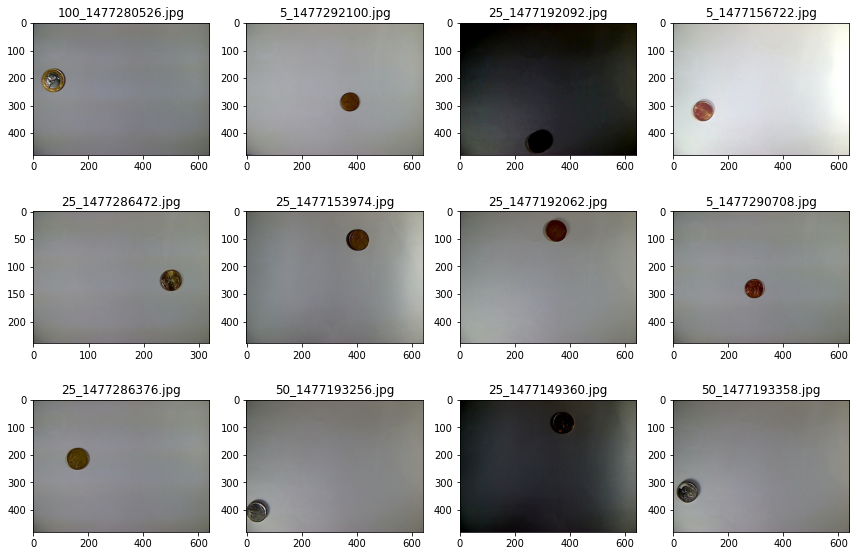

In [ ]:
#Showing some images
import random
import numpy as np
import matplotlib.pyplot as plt
random.shuffle(imgs)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
ax = axes.ravel()

for i in range(12):
  ax[i].set_title(imgs[i][1]) 
  ax[i].imshow(imgs[i][0],cmap=plt.cm.gray)


fig.tight_layout()
plt.show()

Vemos que existem vários desafios:


*   Ruídos
*   Sombra
*   Brilho
*   Escala

O primeiro passo é achar um processo para normalizar as imagens!

....binarize, aplique filtros, teste sistemas de cores distintos....

Mão na massa, agora é com você!



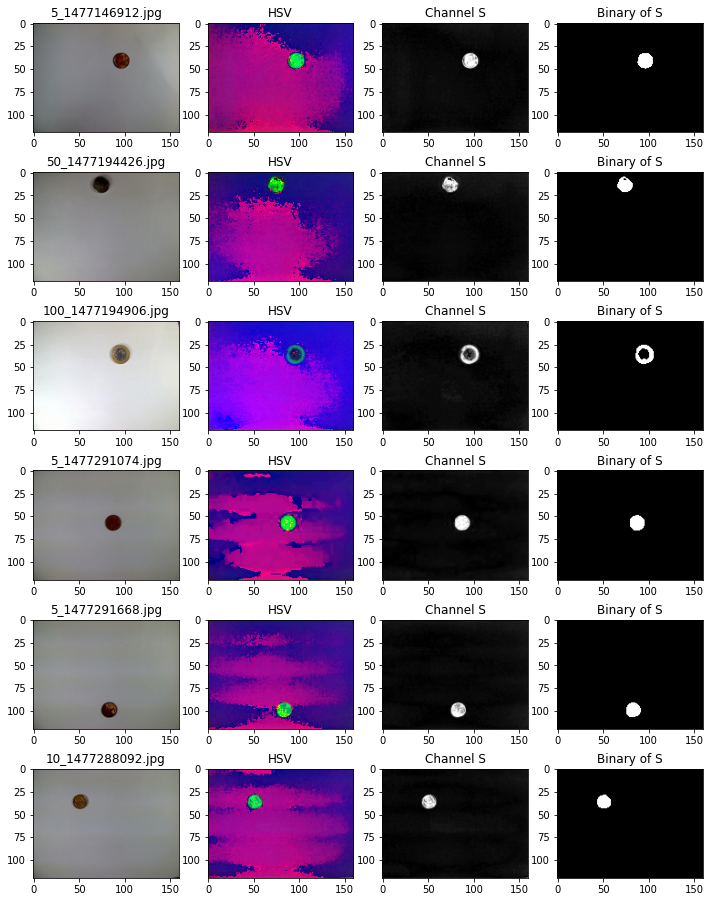

In [ ]:
from skimage import util
from skimage.color import rgb2gray,rgb2hsv
from skimage.filters import threshold_otsu, threshold_local, median
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.transform import resize
import random 
fig, axes = plt.subplots(6, 4, figsize=(12, 16))
ax = axes.ravel()

random.shuffle(imgs)

resulting_imgs = []

for i in range(6):

  
  resized = resize(imgs[i][0],(120, 160),
                       anti_aliasing=True)

  hsv = rgb2hsv(resized)
  
  channel_s = hsv[:,:,1]

  channel_filtered = median(channel_s, np.ones((3, 3)))

  block_size = 20
  local_thresh = threshold_otsu(channel_filtered, block_size)
  binary_s = channel_filtered > local_thresh

  #binary_s = util.invert(binary_s)

  resulting_imgs.append(binary_s)
  

  ax[i*4].set_title(imgs[i][1])
  ax[i*4+1].set_title('HSV')
  ax[i*4+2].set_title('Channel S')
  ax[i*4+3].set_title('Binary of S')
  
  #im_concat = np.concatenate([binary_local,im],axis=1)
  ax[i*4].imshow(resized)
  ax[i*4+1].imshow(hsv,cmap=plt.cm.gray)
  ax[i*4+2].imshow(channel_s,cmap=plt.cm.gray)
  ax[i*4+3].imshow(binary_s,cmap=plt.cm.gray)

  

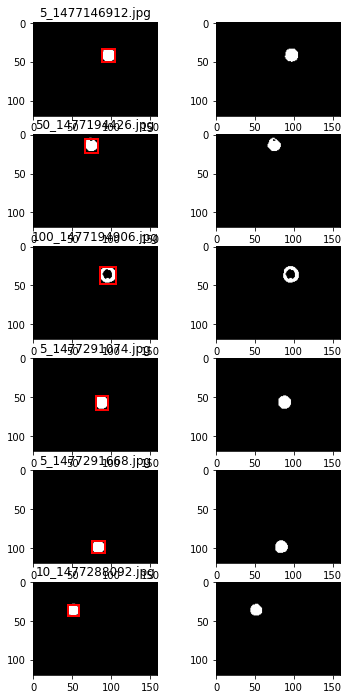

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import label, closing, square
from skimage.measure import regionprops

size = len(resulting_imgs)
fig, axes = plt.subplots(ncols=2, nrows=size, figsize=(6, 12))
for binary,idx in zip(resulting_imgs,range(size)):

  binary = util.img_as_ubyte(binary)
  
  # label image regions
  label_image = label(binary)
  

  
  ax = axes.ravel()
  ax[idx*2].set_title(imgs[idx][1])
  ax[idx*2].imshow(binary,cmap=plt.cm.gray)
  ax[idx*2+1].imshow(label_image,cmap=plt.cm.gray)
  

  r = regionprops(label_image)
  
  for region in r:
    
    # skip small images
    if region['Area'] < 20:
        continue
    
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region['BoundingBox']

    ratio = (maxc - minc) / (maxr - minr)
    
    #Eliminating non squared bbox 
    if not (0.90 < ratio < 1.10):         
        continue

    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax[idx*2].add_patch(rect)

plt.show()

In [ ]:
from skimage.morphology import label, closing, square
from skimage.measure import regionprops

def bbox(image):

  resized = resize(image,(120, 160),
                       anti_aliasing=True)

  hsv = rgb2hsv(resized)
  
  channel_s = hsv[:,:,1]

  channel_filtered = median(channel_s, np.ones((3, 3)))

  block_size = 20
  local_thresh = threshold_otsu(channel_filtered, block_size)
  binary_s = channel_filtered > local_thresh

  binary = util.img_as_ubyte(binary_s)
  
  # label image regions
  label_image = label(binary)
  
  r = regionprops(label_image)
  
  for region in r:
    
    # skip small images
    if region['Area'] < 60:
        continue
    
    # draw rectangle around segmented coins    
    rect = region['BoundingBox']
    
    ratio = 0
    if  abs(rect[2] - rect[0]) != 0:
      ratio = abs(rect[3] - rect[1]) / abs(rect[2] - rect[0])
    
    #Eliminating non squared bbox 
    if not (0.90 < ratio < 1.10):         
        continue
    
    return (rect,binary)

#5,10,25,50,100
stats = [[],[],[],[],[]]

lenght = 50
for idx in range(lenght):

  if idx % 10 == 0:
    print("Processing ", idx," of ",lenght)
  
  res = bbox(imgs[idx][0])
  if res is None:
    continue
  rect = res[0]
  bin = res[1]
  

  w = abs(rect[3] - rect[1]) 
  h = abs(rect[2] - rect[0])

  if w == 0:    
    continue

  cls = int(imgs[idx][1].split('_')[0])  
  
  st = (w,h)
  if cls == 5:
    stats[0].append(st)  
  elif cls == 10:
    stats[1].append(st)  
  elif cls == 25:                     
    stats[2].append(st)  
  elif cls == 50:
    stats[3].append(st)  
  elif cls == 100:
    stats[4].append(st)  

Processing  0  of  50
Processing  10  of  50
Processing  20  of  50
Processing  30  of  50
Processing  40  of  50


In [ ]:
for st in stats:  
  m = tuple(map(np.mean, zip(*st)))
  print(m)


(17.076923076923077, 16.846153846153847)
(14.833333333333334, 14.666666666666666)
(18.4, 18.2)
(18.2, 17.8)
(20.666666666666668, 20.75)
